# S&P 500 Stock Selection
## Creating SQL Database and Data Analysis Using Python
<hr style="border:1px solid gray">

## Project Objective

The primary goal of this project is to find five stocks from the S&P 500 index that can be held together in a portfolio that can potentially beat the index based on both returns and risk. Another goal of this project is to create and store the stock data in an SQL database so that the information can be accessed even offline.

### Steps to find the five stocks:

   1) Retrieve the stock data from the S&P 500 index.
    
   2) Clean and modify the dataset to include stocks that were removed/added based on dates. 
    
   3) Split the dataset to have one part for stock selection and another part for testing the results. We will select five stocks based on the data from the period of 2015-01-01 to 2019-12-31 (5 years) so that we can then test to see how they actually performed in the following period of 2020-01-01 to our current date. 
    
   4) We will compare the results to the S&P 500 index to see if it outperformed or underperformed, and also to select the criteria that gave the best results, if any criteria actually did beat the index.
    
   5) We will then use the chosen criteria to screen for five new stocks to hold in a portfolio, using a more recent time period, that could potentially outperform the index based on both returns and risk. The time period for this selection will be 2019-01-01 to our current date, which will be close to a 5 year period as well.

## Data

The stock data will be downloaded from Yahoo Finance using the yfinance library, and then transferred to an SQL database using the SQL toolkit SQLalchemy and SQlite. There will also be a function within this project to update the SQL database without re-downloading the initial data. The data will then be retrieved from this database in order to do analysis in Python. 

## Addressing Survivorship Bias

As the S&P 500 components get updated periodically, if we do not modify the dataset to include stocks that were removed from the index, then there would be survivorship bias on our final stocks selection as we would not have even considered the stocks that were still in the index during our selection process. Therefore, we need to include those stocks that were removed in the past before conducting the analysis. We also need to include stocks that were added to the index, as we need to make sure that we are not selecting stocks before the date they were actually added.

<hr style="border:1px solid gray">

### Preliminaries

In [144]:
# Import packages required.
import pandas as pd
import numpy as np
import yfinance as yf
from sqlalchemy import create_engine
import datetime 
import matplotlib.pyplot as plt

In [36]:
# Getting dataframe with ticker names and date added to S&P500 from Wikipedia page.
SPYtickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0][['Symbol', 'Date added']]
SPYtickers

,Symbol,Date added
0,MMM,1957-03-04
1,AOS,2017-07-26
2,ABT,1957-03-04
3,ABBV,2012-12-31
4,ACN,2011-07-06
...,...,...
498,YUM,1997-10-06
499,ZBRA,2019-12-23
500,ZBH,2001-08-07
501,ZION,2001-06-22


In [37]:
# Creating a list with all current SPY ticker names. Removed tickers will be added to this list later as well.
SPYalltickers = SPYtickers['Symbol'].to_list()

In [75]:
# Analysis starting date will be 2015-01-01, so filtering out another dataframe that only lists names added after 2015-01-01.
SPY2015 = SPYtickers[SPYtickers['Date added'] > '2015-01-01']
SPY2015

,Symbol,Date added
1,AOS,2017-07-26
5,ATVI,2015-08-31
9,AAP,2015-07-09
15,ALK,2016-05-13
16,ALB,2016-07-01
...,...,...
478,WAB,2019-02-27
481,WBD,2022-04-11
487,WST,2020-05-22
493,WTW,2016-01-05


In [10]:
# Find the tickers that had been removed from the index.
# On the same wikipedia page, there is another table that lists date and component changes of the S&P 500.
removed_tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[1][['Date', 'Removed']]
removed_tickers

Date Removed                          
                  Date  Ticker                  Security
0        June 20, 2023    DISH              Dish Network
1          May 4, 2023     FRC       First Republic Bank
2       March 20, 2023    LUMN        Lumen Technologies
3       March 15, 2023    SBNY            Signature Bank
4       March 15, 2023    SIVB       SVB Financial Group
..                 ...     ...                       ...
320       June 9, 1999     HPH  Harnischfeger Industries
321  December 11, 1998     LDW                     Amoco
322  December 11, 1998     GRN                General Re
323  December 11, 1998     SUN                SunAmerica
324      June 17, 1997     USL                    USLife

[325 rows x 3 columns]

In [30]:
# Set date as index
removed_tickers = removed_tickers.set_index(removed_tickers['Date']['Date'])
removed_tickers.head()

Date Removed                     
                          Date  Ticker             Security
Date                                                       
June 20, 2023    June 20, 2023    DISH         Dish Network
May 4, 2023        May 4, 2023     FRC  First Republic Bank
March 20, 2023  March 20, 2023    LUMN   Lumen Technologies
March 15, 2023  March 15, 2023    SBNY       Signature Bank
March 15, 2023  March 15, 2023    SIVB  SVB Financial Group

In [31]:
# Setting index as datetime and filtering for start date later than 2015-01-01. 
# Dropping null values as there were rows in the Wikipedia table that were blank in the 'Removed' column.
removed_tickers.index = pd.to_datetime(removed_tickers.index)
removed_tickers = removed_tickers[removed_tickers.index > '2015-01-01']
removed_tickers = removed_tickers['Removed'].dropna()
removed_tickers

,Ticker,Security
Date,,
2023-06-20,DISH,Dish Network
2023-05-04,FRC,First Republic Bank
2023-03-20,LUMN,Lumen Technologies
2023-03-15,SBNY,Signature Bank
2023-03-15,SIVB,SVB Financial Group
...,...,...
2015-03-23,AVP,Avon Products
2015-03-18,CFN,Carefusion
2015-03-12,PETM,PetSmart


In [38]:
# Adding this list of removed tickers to our SPY tickers list.
SPYalltickers.extend(removed_tickers['Ticker'])

In [39]:
# Renaming tickers 'BF.B' and 'BRK.B' to 'BF-B' and 'BRK-B' to make them match with how they are named on Yahoo Finance.
# If tickers do not match, it will not successfully pull the data.
SPYalltickers = ['BF-B' if i=='BF.B' else i for i in SPYalltickers]
SPYalltickers = ['BRK-B' if i=='BRK.B' else i for i in SPYalltickers]

In [42]:
# Checking for duplicates; important when exporting to SQL as it can cause errors if not accounted for.
print(len(SPYalltickers)) 
print(len(set(SPYalltickers)))
# There are duplicates in the list as the lengths do not match. 
# Remove duplicates.
SPYalltickers = list(set(SPYalltickers))

683
683


In [43]:
# Creating function to import data from yfinance to prepare for export to SQL database.
def getdata(tickers):
    data = []
    for ticker in tickers:
        # reset_index to move 'Date' out of index and into column.
        data.append(yf.download(ticker, start='2015-01-01').reset_index()) 
    return data

In [46]:
%%time
# Running function to a variable and displaying processing time to see how long it'll take to download data from yfinance.
# Each ticker will have its own dataframe with columns; 'Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', and 'Volume'.
# NOTE: No need to run again after first import.
SPY = getdata(SPYalltickers)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********


1 Failed download:
['LO']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2015-01-01 -> 2023-08-10)')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['XL']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******


1 Failed download:
['AGN']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******


1 Failed download:
['SWY']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2015-01-01 -> 2023-08-10)')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['RAI']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2015-01-01 -> 2023-08-10)')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['CAM']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2015-01-01 -> 2023-08-10)')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['GMCR']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2015-01-01 -> 2023-08-10)')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['CELG']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['ADS']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['MON']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['YHOO']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2015-01-01 -> 2023-08-10)')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******


1 Failed download:
['KRFT']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2015-01-01 -> 2023-08-10)')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['INFO']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['MXIM']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['BCR']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2015-01-01 -> 2023-08-10)')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******


1 Failed download:
['ARG']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2015-01-01 -> 2023-08-10)')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['DPS']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2015-01-01 -> 2023-08-10)')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['TIF']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******


1 Failed download:
['CMCSK']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2015-01-01 -> 2023-08-10)')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['XEC']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['WIN']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******


1 Failed download:
['SIAL']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2015-01-01 -> 2023-08-10)')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['ENDP']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['DNR']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['QEP']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%***********************]  1 of 1 completed


1 Failed download:
['CXO']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['STJ']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2015-01-01 -> 2023-08-10)')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['NBL']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['TWC']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2015-01-01 -> 2023-08-10)')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['LLL']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['CLX']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2015-01-01 -> 2023-08-10)')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['WFM']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2015-01-01 -> 2023-08-10)')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******


1 Failed download:
['PBCT']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['TWTR']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['DRE']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['BBBY']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['FTR']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['ALXN']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['TYC']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2015-01-01 -> 2023-08-10)')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['ETFC']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['APC']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['RHT']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['VAR']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['NLSN']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['GGP']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2015-01-01 -> 2023-08-10)')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******


1 Failed download:
['LVLT']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2015-01-01 -> 2023-08-10)')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['FBHS']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['KSU']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['DWDP']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['HFC']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['MJN']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2015-01-01 -> 2023-08-10)')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['CVC']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2015-01-01 -> 2023-08-10)')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['CFN']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2015-01-01 -> 2023-08-10)')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['XLNX']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['AVP']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******


1 Failed download:
['SPLS']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2015-01-01 -> 2023-08-10)')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['RTN']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******


1 Failed download:
['SIVB']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%***********************]  1 of 1 completed


1 Failed download:
['JOY']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2015-01-01 -> 2023-08-10)')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['SNDK']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2015-01-01 -> 2023-08-10)')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['TSS']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['HSP']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2015-01-01 -> 2023-08-10)')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['CERN']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['WYN']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2015-01-01 -> 2023-08-10)')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['BRCM']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2015-01-01 -> 2023-08-10)')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******


1 Failed download:
['TE']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2015-01-01 -> 2023-08-10)')



[*********************100%***********************]  1 of 1 completed


1 Failed download:
['LM']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%***********************]  1 of 1 completed


1 Failed download:
['FLIR']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['STI']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['CTXS']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['HCBK']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2015-01-01 -> 2023-08-10)')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['BXLT']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2015-01-01 -> 2023-08-10)')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['FDO']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2015-01-01 -> 2023-08-10)')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['LLTC']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2015-01-01 -> 2023-08-10)')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******


1 Failed download:
['ESV']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%***********************]  1 of 1 completed


1 Failed download:
['DTV']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['VIAB']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['WCG']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['FRC']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%***********************]  1 of 1 completed


1 Failed download:
['CPGX']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2015-01-01 -> 2023-08-10)')



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Wall time: 3min 25s


### Regarding Failed Downloads

When the above cell is run, there will be notifications of failed downloads from Yahoo Finance. This is because these companies are no longer listed on Yahoo Finance so there is nothing to retrieve. These tickers were found on the Wikipedia table listing of removed tickers so it was included in the initial SPY stock list.

A few examples of why these are no longer listed on Yahoo Finance;

YHOO - Used to be Yahoo! but was acquired by Verizon Communications Inc., so it no longer is listed on Yahoo Finance

MXIM - Company named Maxim Integrated acquired by another S&P 500 constituent, Analog Devices (listed as ADI).

LLTC - Company named Linear Technology, also acquired by Analog Devices.

BBBY - Bed Bath & Beyond, went bankrupt, delisted from major exchanges, and defunct.

TWTR - Acquired by Elon Musk and taken off public market

One thing to keep in mind here is that the dataset is not perfect. For example, companies such as Twitter and Bed Bath & Beyond may have been considered during a stock screening process done before 2020, but in this case have been completely taken out of the dataset. Even though this is important to note, the dataset is still sufficient to achieve the goal of selecting five stocks using the most recent data.

### Creating SQL Database 

In [47]:
# Connecting to SQL database named 'SPY500'.
engine = create_engine('sqlite:///SPY500')

In [49]:
# Creating a function to export each stock dataframe to SQL database.
# The ticker names will be the table names in the SQL database, and the dataframes will be the data.
# Added exception handling in order to inform if database has already been created.
def export_sql(dataframes, tickers, engine):
    """
    Exports stock dataframes to SQL database.
    Will not run if database name already exists.
    Ensure no duplicates in ticker list.
    """
    try:
        for dataframe, ticker in zip(dataframes, tickers):
            dataframe.to_sql(ticker, engine, index=False)
        print('Export to SQL database complete')
    except:
        print('Error: Database already exists')     

In [50]:
%%time
# Running function to create the SQL database along with displaying processing time.
export_sql(SPY, SPYalltickers, engine)

Export to SQL database complete
Wall time: 4min 35s


### Updating SQL Database

In [51]:
# Creating function to update SQL database .
def sql_updater(ticker, start='2023-07-01'):
    """
    Updates SQL database without needing to re-download all initial data
    """
    # Get the latest date from database table.
    max_date = pd.read_sql(f'SELECT MAX(Date) FROM {ticker}', engine).values[0][0]
    print('Latest date: ' + max_date)
    # Added .strip() in order to remove quotations before downloading as these were added for SQL coding.
    new_data = yf.download(ticker.strip('\"'), start=pd.to_datetime(max_date))
    new_rows = new_data[new_data.index > max_date]
    new_rows.to_sql(ticker, engine, if_exists='append')
    print(str(len(new_rows)) + ' new rows imported to DB')

In [58]:
%%time
# Set an if statement to only update during weekends.
# This is to avoid updating SQL database while market is open as values will constantly change until market close.
# Must first run following cell that defines 'tickers' variable. 
if datetime.datetime.today().weekday() < 5:
    print('Wait until weekend to update SQL database.')
else:
    for ticker in tickers: 
        sql_updater(ticker)

Wait until weekend to update SQL database.
Wall time: 998 µs


In [59]:
# Getting an overview of how the SQL database looks like, with ticker names as the table names. 
# Note: I also use the tool 'DB Browser for SQLite' that allows me to view the database and execute SQL code directly on it.
# Ensuring that the number of rows is correct, which should be 683. The tickers that failed to download are empty tables.
pd.read_sql('SELECT * FROM sqlite_master', engine)

,type,name,tbl_name,rootpage,sql
0,table,RF,RF,2,"CREATE TABLE ""RF"" (\n\t""Date"" DATETIME, \n\t""O..."
1,table,MCHP,MCHP,48,"CREATE TABLE ""MCHP"" (\n\t""Date"" DATETIME, \n\t..."
2,table,PH,PH,93,"CREATE TABLE ""PH"" (\n\t""Date"" DATETIME, \n\t""O..."
3,table,BKR,BKR,138,"CREATE TABLE ""BKR"" (\n\t""Date"" DATETIME, \n\t""..."
4,table,NUE,NUE,183,"CREATE TABLE ""NUE"" (\n\t""Date"" DATETIME, \n\t""..."
...,...,...,...,...,...
678,table,FRC,FRC,25798,"CREATE TABLE ""FRC"" (\n\t""Date"" TEXT, \n\t""Open..."
679,table,CPGX,CPGX,25799,"CREATE TABLE ""CPGX"" (\n\t""Date"" TEXT, \n\t""Ope..."
680,table,IVZ,IVZ,25800,"CREATE TABLE ""IVZ"" (\n\t""Date"" DATETIME, \n\t""..."
681,table,RIG,RIG,25845,"CREATE TABLE ""RIG"" (\n\t""Date"" DATETIME, \n\t""..."


### Creating Dataframe From SQL Database

In [60]:
# Creating a variable to store a list of all the ticker names from SQL database.
tickers = pd.read_sql('SELECT name FROM sqlite_master WHERE type="table"', engine)['name'].to_list()

In [61]:
# Need to modify some tickers as it will cause issues when they are inserted into SQL code in the following cell.
tickers = ['"ALL"' if i=='ALL' else i for i in tickers] # need to modify otherwise SQL reads it as 'FROM ALL'
tickers = ['"ON"' if i=='ON' else i for i in tickers] # need to modify otherwise SQL reads it as 'FROM ON'
tickers = ['"BF-B"' if i=='BF-B' else i for i in tickers] # need to modify due to SQL reading "-"
tickers = ['"BRK-B"' if i=='BRK-B' else i for i in tickers] # need to modify due to SQL reading "-"
tickers

['RF',
 'MCHP',
 'PH',
 'BKR',
 'NUE',
 'NTRS',
 'VRTX',
 'PCP',
 'SPG',
 'RL',
 'NFLX',
 'ACN',
 'KDP',
 'ZION',
 'LO',
 'DAL',
 'XL',
 'GOOGL',
 'MCD',
 'TER',
 'LIN',
 'DOV',
 'PFG',
 'ENPH',
 'STZ',
 'CPRI',
 'AJG',
 'HSY',
 'CME',
 'DHR',
 'ORLY',
 'PG',
 'KMB',
 'DFS',
 'NTAP',
 'PDCO',
 'PAYC',
 'DGX',
 'SLG',
 'VRSN',
 'D',
 'SBUX',
 'AGN',
 'SWKS',
 'PXD',
 'AMZN',
 'PPG',
 'BBWI',
 'J',
 'HRL',
 'PPL',
 'EXC',
 'CDNS',
 'HD',
 'WYNN',
 'CHTR',
 'MTB',
 'FTV',
 'AAL',
 'BEN',
 'TAP',
 'STX',
 'SWY',
 'ANSS',
 'SNI',
 'NE',
 'MRK',
 'CF',
 'RJF',
 'RAI',
 'LUMN',
 'COV',
 'HLT',
 'MUR',
 'IFF',
 'PHM',
 'HBAN',
 'CAM',
 'ADT',
 'NSC',
 'JKHY',
 'CTVA',
 'LHX',
 'HOG',
 'HP',
 'COO',
 'GMCR',
 'ACE',
 'LH',
 'BXP',
 'ED',
 'FL',
 'BKNG',
 'CNX',
 'CELG',
 'SBNY',
 'FE',
 'BA',
 'TRGP',
 '"BRK-B"',
 'TMUS',
 'PENN',
 'GEN',
 'NVR',
 'SLB',
 'MNST',
 'FOX',
 'UNM',
 'ADS',
 'DNB',
 'MOS',
 'FDX',
 'BMY',
 'ORCL',
 'TDY',
 'AME',
 'FCX',
 'RCL',
 'JCI',
 'BRO',
 'MON',
 'OI',
 'YHO

In [63]:
# Creating a function to clean and combine all the tables into one table.
def stocks_import(tickers):
    """
    Combines all tables from SQL database into one Pandas dataframe
    """
    # Creating empty dataframe.
    df_ = pd.DataFrame() 
    # Loop for list of names.
    for ticker in tickers:
        # Creating dataframe from SQL.
        df = pd.read_sql(f'SELECT * FROM {ticker}', engine)
        # Cleaning 'Date' column and setting it as index.
        df['Date'] = df['Date'].str.split(' ').str[0]
        df = df.set_index('Date')
        # Selecting only 'Adj Close' column and renaming the column as ticker name for identification.
        df = df[['Adj Close']]
        df = df.rename(columns={'Adj Close': ticker})
        # Combining dataframes horizontally.
        df_ = pd.concat([df_, df], axis=1)
    return df_

In [64]:
%%time
# Running function with list of ticker names to create combined dataframe for analysis along with processing time.
df = stocks_import(tickers)

Wall time: 22.9 s


In [65]:
# Dataframe prepared and ready for analysis, with each column as a different ticker showing adjusted close price. 
# Index is set as dates.
df

,RF,MCHP,PH,BKR,NUE,NTRS,VRTX,PCP,SPG,RL,...,BAC,STLD,ACGL,CTRA,BIIB,FRC,CPGX,IVZ,RIG,HWM
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,8.054943,19.114405,110.646973,31.563976,39.128372,54.705898,123.070000,NaN,122.824875,153.534058,...,15.146550,16.332380,19.496668,23.673445,342.010010,NaN,NaN,27.212114,17.075876,NaN
2015-01-05,7.779033,18.688410,105.901054,30.996422,37.635422,52.697464,121.029999,NaN,123.328575,149.156952,...,14.706536,15.347519,19.379999,22.375727,336.739990,NaN,NaN,26.419527,15.869632,NaN
2015-01-06,7.518458,18.326311,104.350487,30.900892,37.092525,51.215412,117.360001,NaN,126.761330,146.247192,...,14.266525,14.904326,19.423332,22.061132,334.649994,NaN,NaN,25.870283,15.511528,NaN
2015-01-07,7.564443,18.428551,105.164330,31.732571,37.435833,52.041481,120.660004,NaN,129.094040,149.911560,...,14.334221,15.117711,19.536667,22.249887,353.239990,NaN,NaN,26.210951,15.360747,NaN
2015-01-08,7.679403,19.016422,108.488205,32.047241,38.345989,52.851345,123.970001,NaN,128.908478,149.735504,...,14.630381,15.642974,19.876667,22.698187,350.250000,NaN,NaN,26.669821,15.332478,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-04,20.610001,83.459999,414.149994,35.320000,167.759995,80.250000,340.480011,NaN,118.290001,131.740005,...,31.299999,103.790001,76.720001,27.570000,268.920013,NaN,NaN,16.650000,8.490000,49.049999
2023-08-07,20.980000,84.809998,424.950012,35.590000,169.259995,80.849998,345.320007,NaN,119.660004,131.619995,...,31.879999,104.459999,78.230003,27.799999,271.230011,NaN,NaN,16.980000,8.130000,50.450001
2023-08-08,20.900000,84.529999,425.119995,35.650002,169.910004,79.589996,344.470001,NaN,119.000000,130.149994,...,31.270000,103.949997,76.349998,27.600000,274.140015,NaN,NaN,16.750000,8.270000,50.500000


## More Data Cleaning/Modifying
### Modifying Dataframe For Removed/Added Stocks

In [69]:
# Setting index to datetime
df.index = pd.to_datetime(df.index)

In [77]:
# Remove quotations around any ticker names as I had set this when importing from SQL.
df.columns = df.columns.str.replace('\"', '') 

In [78]:
# Creating function to remove stock prices for dates after being removed from index.
def filter_remove(ticker):
    df[ticker] = df[df[ticker].index <= removed_tickers[removed_tickers['Ticker'] == ticker].index[0]][ticker]

In [79]:
# Creating function to remove stock prices for dates before being added to index.
def filter_add(ticker):
    df[ticker] = df[df[ticker].index > SPY2015[SPY2015['Symbol'] == ticker]['Date added'].values[0]][ticker]

In [80]:
# Running both functions on removed tickers list and added tickers list.
for ticker in removed_tickers['Ticker']:
    filter_remove(ticker)
for ticker in SPY2015['Symbol']:
    filter_add(ticker)

In [81]:
# Change column types to float.
df = df.astype('float')

In [82]:
# Drop columns that have all null values.
df = df.dropna(axis=1, how='all')

## Analysis
<hr style="border:1px solid gray">

##### The two criteria we will use for choosing our five stocks to hold in a portfolio will be based on the Sharpe ratio and the mean expected daily returns.

We will first choose five stocks based on the highest Sharpe ratios, and then choose five stocks based on the highest mean daily expected returns. We will then compare this to the Sharpe ratio, mean daily expected returns, and cumulative returns between the two portfolios and the S&P 500 index.

We first need to find out which criteria produces the best potential results. In order to do this, we will select stocks based on the period from 2015-01-01 to 2019-12-31 (5-year period). We will then see how these five stocks performed from the period of 2020-01-01 until now. We then check whether stocks chosen based on Sharpe ratio or mean expected daily returns performed better in a portfolio, and how they compared to the index in the same period. 

Whichever criteria performed best, we will then use that same criteria to select another five stocks for a new portfolio, but this time based on the period from 2019-01-01 until now. Of course, the actual performance of the future will not be known, but based on the criteria we tested, this portfolio will potentially outperform the index in the following years based on both return and risk. 

#### Note on Sharpe ratio:
For the Sharpe ratio, a risk-free rate is included in the calculation. For simplication, we have not included the risk-free rate in our calculations here as it does not affect our results. However, if I were to include it, I would use the U.S. 10-year treasury rate.

In [84]:
# Filtering the dataset on date before 2020-01-01 to calculate criteria for initial stock selection.
df_main = df[df.index < '2020-01-01']

In [85]:
# Filtering the dataset for test to see how chosen stocks actually performed for period after 2020-01-01.
df_test = df[df.index >= '2020-01-01']

In [86]:
# Changing values to show percentage changes.
df_main_returns = df_main.pct_change()

### Stock Selection Based On Sharpe Ratio

In [87]:
# Calculated Sharpe ratios and displaying the top five stocks with highest Sharpe ratios.
(df_main_returns.mean() / df_main_returns.std()).nlargest(5)

LYV     0.384289
LVS     0.258301
CDW     0.248122
STE     0.180690
ZBRA    0.177726
dtype: float64

In [88]:
# Stock selection based on Sharpe ratio.
df_main_sharpe = ['LYV', 'LVS', 'CDW', 'STE', 'ZBRA']

### Stock Selection Based On Mean Daily Expected Returns

In [89]:
# Calculated mean daily expected returns and displaying top five stocks with highest mean daily expected return.
df_main_returns.mean().nlargest(5)

LVS     0.003787
LYV     0.003055
CDW     0.002836
AMD     0.002386
NVDA    0.002344
dtype: float64

In [90]:
# Stock selection based on mean daily expected return. 
df_main_mean = ['LVS', 'LYV', 'CDW', 'AMD', 'NVDA']

### Calculating Performance From Jan. 1, 2020 Onwards

We will calculate each of our five stock selection as holdings in seperate portfolios, giving equal weighting to all five stocks. We will have one portfolio with the five stocks selected based on Sharpe ratio, and another portfolio with the five stocks selected based on mean daily expected returns. We will calculate the portfolios' mean daily expected return, daily standard deviation, Sharpe ratio, and cumulative returns, and will compare these with the S&P 500. 

### S&P 500 Metrics Calculations

In [92]:
# Import S&P 500 stock data
SPY_main = yf.download('^GSPC', start='2015-01-01')

[*********************100%***********************]  1 of 1 completed


In [97]:
# Changing values to show percentage changes.
SPY_main_returns = SPY_main[SPY_main.index >= '2020-01-01']['Adj Close'].pct_change()

In [98]:
# S&P 500 mean daily expected returns.
SPY_main_returns.mean()

0.000462336044480167

In [99]:
# S&P 500 daily standard deviation.
SPY_main_returns.std()

0.015051596673550478

In [101]:
# S&P 500 Sharpe ratio.
SPY_main_returns.mean() / SPY_main_returns.std()

0.030716744177221422

In [102]:
# S&P 500 cumulative return.
((SPY_main_returns + 1).cumprod() - 1)[-2]

0.3713675666512859

### Sharpe Ratio Portfolio Metrics Calculations

##### Note: We will be calling the portfolio with stocks selected based on Sharpe ratio as 'Sharpe Portfolio' and portfolio with stocks selected based on mean daily expected returns as 'Mean Portfolio'.

In [107]:
# Subsetting date after 2020-01-01 on dataset for testing selected stocks.
df_test_sharpe = df[df.index >= '2020-01-01'][df_main_sharpe]

In [108]:
# Calculating weights for each stock in portfolio. As we are doing equal weighting for five stocks, it is 20% weight on each.
weights = np.ones(len(df_test_sharpe.columns))\
            /(np.ones(len(df_test_sharpe.columns))).sum()
weights

array([0.2, 0.2, 0.2, 0.2, 0.2])

In [109]:
# Change values to percentage changes.
df_test_sharpe = df_test_sharpe.pct_change()

In [110]:
# Sharpe portfolio mean daily expected return.
(W * df_test_sharpe.mean()).sum() 

0.0005455824289109516

In [111]:
# Sharpe portfolio daily standard deviation.
(W.dot(df_test_sharpe.cov().dot(W)))**(1/2)

0.020380758059000307

In [112]:
# Sharpe portfolio Sharpe ratio
df_test_sharpe.mean().dot(W) \
        / (W.dot(df_test_sharpe.cov().dot(W)))**(1/2)

0.02676948655842652

In [113]:
# Sharpe portfolio cumulative returns
((df_test_sharpe.mean(axis=1) + 1).cumprod() - 1).tail(1)

Date
2023-08-10    0.357367
dtype: float64

### Mean Portfolio Metrics Calculations

In [114]:
# Subsetting date after 2020-01-01 on dataset for testing selected stocks.
df_test_mean = df[df.index >= '2020-01-01'][df_main_mean]

In [115]:
# Change values to percentage changes.
df_test_mean = df_test_mean.pct_change()

In [116]:
# Mean portfolio mean daily expected return.
(W * df_test_mean.mean()).sum() 

0.0011913644485392438

In [117]:
# Mean portfolio daily standard deviation.
(W.dot(df_test_mean.cov().dot(W)))**(1/2)

0.02393379464733596

In [118]:
# Mean portfolio Sharpe ratio.
df_test_mean.mean().dot(W) \
        / (W.dot(df_test_mean.cov().dot(W)))**(1/2)

0.049777499393388214

In [119]:
# Mean portfolio cumulative returns
((df_test_mean.mean(axis=1) + 1).cumprod() - 1).tail(1)

Date
2023-08-10    1.26844
dtype: float64

### Result Comparisons

In [124]:
# Creating dataframe to display summary of results
data = {'S&P 500': [SPY_main_returns.mean(), SPY_main_returns.std(), SPY_main_returns.mean() / SPY_main_returns.std(),\
                ((SPY_main_returns + 1).cumprod() - 1)[-2]],
        'Sharpe Portfolio': [(W * df_test_sharpe.mean()).sum(),\
                            (W.dot(df_test_sharpe.cov().dot(W)))**(1/2),\
                             df_test_sharpe.mean().dot(W) / (W.dot(df_test_sharpe.cov().dot(W)))**(1/2),\
                             ((df_test_sharpe.mean(axis=1) + 1).cumprod() - 1).tail(1)[0]], 
        'Mean Portfolio': [(W * df_test_mean.mean()).sum(),\
                            (W.dot(df_test_mean.cov().dot(W)))**(1/2),\
                             df_test_mean.mean().dot(W) / (W.dot(df_test_mean.cov().dot(W)))**(1/2),\
                             ((df_test_mean.mean(axis=1) + 1).cumprod() - 1).tail(1)[0]]}
df_compare = pd.DataFrame(data, index=['Expected Daily Return', 'Standard Deviation', 'Sharpe Ratio', 'Cumulative Return'])

In [125]:
# Display comparison dateframe
df_compare

,S&P 500,Sharpe Portfolio,Mean Portfolio
Expected Daily Return,0.000462,0.000546,0.001191
Standard Deviation,0.015052,0.020381,0.023934
Sharpe Ratio,0.030717,0.026769,0.049777
Cumulative Return,0.371368,0.357367,1.268440


As we can see with the summary results, the 'Mean Portfolio' that held companies LVS, LYV, CDW, AMD, and NVDA greatly outperformed both the S&P 500 and Sharpe Portfolio. Although it had the highest standard deviation, it had the highest mean daily expected return and highest cumulative return. When comparing the 'Mean Portfolio' return with its risk, it had the highest Sharpe ratio as well. Therefore, selecting five stocks to hold in a portfolio based on mean daily expected return seems to be the best option.

### Visualizing Cumulative Returns

Just to get a visual, let's plot the cumulative returns of all three options.

In [126]:
# S&P 500 cumulative return.
c_df = ((SPY_main_returns + 1).cumprod() - 1)

In [127]:
# Sharpe portfolio cumulative returns.
c_df2 = ((df_test_sharpe.mean(axis=1) + 1).cumprod() - 1)

In [128]:
# Mean portfolio cumulative returns.
c_df3 = ((df_test_mean.mean(axis=1) + 1).cumprod() - 1)

In [131]:
# Combining all three dataframes.
c_df4 = pd.concat([c_df, c_df2, c_df3], axis=1)

In [132]:
# Renaming columns on combined dataframe.
c_df4.columns = ['S&P 500', 'Sharpe Portfolio', 'Mean Portfolio']

Text(0.5, 1.0, 'Cumulative Returns')

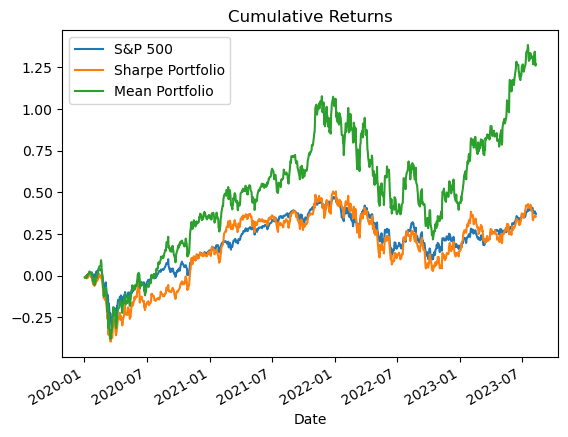

In [146]:
# Lineplot.
c_df4.plot()
plt.title('Cumulative Returns')

### Comparing With Individual Stocks

One more thing I want to compare the portfolios and index with are the mean daily expected returns, standard deviations, Sharpe ratios, and cumulative returns of the individual stocks. I want to do this because I want to see if holding the five stocks in a portfolio with equal weighting would be better than holding each stock individually.

In [156]:
# All the stocks selected for both portfolios. There is overlap with LVS, LYV, and CDW.
final_tickers = ['LVS', 'LYV', 'CDW', 'AMD', 'NVDA', 'STE', 'ZBRA']

In [157]:
# Subsetting date for after 2020-01-01 with only selected stocks.
df_test_stocks = df[df.index >= '2020-01-01'][['LYV', 'LVS', 'CDW', 'STE', 'ZBRA', 'AMD', 'NVDA']]

In [158]:
# Changing values to percentage changes.
df_test_stocks = df_test_stocks.pct_change()

In [159]:
# Stocks mean daily expected returns.
df_test_stocks.mean()

LYV     0.000741
LVS     0.000287
CDW     0.000673
STE     0.000677
ZBRA    0.000350
AMD     0.001482
NVDA    0.002774
dtype: float64

In [160]:
# Stocks daily standard deviation.
df_test_stocks.std()

LYV     0.032601
LVS     0.031405
CDW     0.022303
STE     0.019799
ZBRA    0.026906
AMD     0.034421
NVDA    0.035154
dtype: float64

In [161]:
# Stocks Sharpe ratio.
df_test_stocks.mean() / df_test_stocks.std()

LYV     0.022729
LVS     0.009125
CDW     0.030182
STE     0.034196
ZBRA    0.013016
AMD     0.043048
NVDA    0.078920
dtype: float64

In [162]:
# Stocks cumulative return.
df_stocks = (df_test_stocks + 1).cumprod() - 1

In [163]:
# Showing last row with latest cumulative return.
df_stocks.tail(1)

,LYV,LVS,CDW,STE,ZBRA,AMD,NVDA
Date,,,,,,,
2023-08-10,0.210043,-0.170517,0.466897,0.545583,-0.014355,1.24501,6.093725


In [165]:
# Creating a function to create a dataframe with all the calculated metrics for selected stocks.
def stock_connect(tickers):
    """
    Combines mean expected daily return, standard deviation, Sharpe ratio, and cumulative return
    into one dataframe for a list of tickers.
    """
    df_ = pd.DataFrame()
    for ticker in tickers:
        data = {ticker: [df_test_stocks[ticker].mean(), df_test_stocks[ticker].std(), \
                    (df_test_stocks[ticker].mean() / df_test_stocks[ticker].std()), \
                    ((df_test_stocks + 1).cumprod() - 1)[ticker].tail(1)[0]]}
        df_ = pd.concat([df_, pd.DataFrame(data, index=['Expected Daily Return', 'Standard Deviation',\
                                                        'Sharpe Ratio', 'Cumulative Return'])], axis=1)
    return df_

In [166]:
# Running function and storing the resulting dataframe.
df_stocks_final = stock_connect(final_tickers)

In [167]:
# Combining stocks dataframe with portfolios/index to get one dataframe for easy comparison.
pd.concat([prac_df, df_stocks_final], axis=1)

,SPY,Sharpe Portfolio,Mean Portfolio,LVS,LYV,CDW,AMD,NVDA,STE,ZBRA
Expected Daily Return,0.000462,0.000546,0.001191,0.000287,0.000741,0.000673,0.001482,0.002774,0.000677,0.000350
Standard Deviation,0.015052,0.020381,0.023934,0.031405,0.032601,0.022303,0.034421,0.035154,0.019799,0.026906
Sharpe Ratio,0.030717,0.026769,0.049777,0.009125,0.022729,0.030182,0.043048,0.078920,0.034196,0.013016
Cumulative Return,0.371368,0.357367,1.268440,-0.170517,0.210043,0.466897,1.245010,6.093725,0.545583,-0.014355


From the summary dataframe, we can see that our 'Mean Portfolio' had higher cumulative returns than all selected stocks except for NVDA. NVDA had an exceptional run during this time period, with a cumulative return of over 600%. However, it would have been incredibily lucky to just have chosen NVDA out of all the other stocks. Also, even though the 'Mean Portfolio' actually had a lower Sharpe ratio than NVDA, it had less risk as we can see from the lower standard deviation. Other than NVDA, the 'Mean Portfolio' had the highest Sharpe ratio compared to the other options. The 'Mean Portfolio', which selected five stocks based on the highest mean daily expected returns, was still a great choice, especially compared to simply choosing the index.

### Criteria to use: choose five stocks based on mean daily expected returns.
<hr style="border:1px solid gray">

### Selecting Five Stocks For Current Portfolio

Now, we will select five stocks to hold in a new portfolio based on the period from 2019-01-01 until now using the criteria of selecting the stocks with the highest mean daily expected returns, as this showed it had the best results. 

In [153]:
# Subset dataframe for 2019-01-01 and later
df_select = df[df.index >= '2019-01-01']

In [154]:
# Change values to percentage changes.
df_select = df_select.pct_change()

In [155]:
# Calculate mean daily expected returns and display the top five stocks with highest values.
df_select.mean().nlargest(5)

ON      0.002792
NVDA    0.002735
FICO    0.002240
CEG     0.002139
AMD     0.002111
dtype: float64

## Final Results 
##### The five selected stocks to hold currently based on the analysis are:

##### 1) ON - ON Semiconductor Corporation
##### 2) NVDA - NVIDIA Corporation
##### 3) FICO - Fair Isaac Corporation
##### 4) CEG - Constellation Energy Corporation
##### 5) AMD - Advanced Micro Devices, Inc.